In [336]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, filters, measure
from skimage.color import rgb2lab
from skimage.util import img_as_float
from scipy.stats import norm as scipy_norm
from sklearn.cluster import KMeans



In [337]:
def superpixel_region_proposals(image, max_regions=10):
	
	image_float = img_as_float(image)
	segments = segmentation.slic(image_float, n_segments=500, compactness=0.1, start_label=1, sigma=1)
	proposals = []

	for seg_val in np.unique(segments):
		mask = (segments == seg_val)
		region = image[mask]
		color_var = np.var(region, axis=0).mean()
		size = np.sum(mask)

		# Score favors small, low-variance regions
		score = (1 / (1 + color_var)) * (1 / size**2)
		proposals.append((score, mask))

	proposals.sort(key=lambda x: -x[0])
	print(len(proposals))
	return [p[1] for p in proposals[:max_regions]]



In [338]:
image = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00003.jpeg"
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

scale = 1
image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))

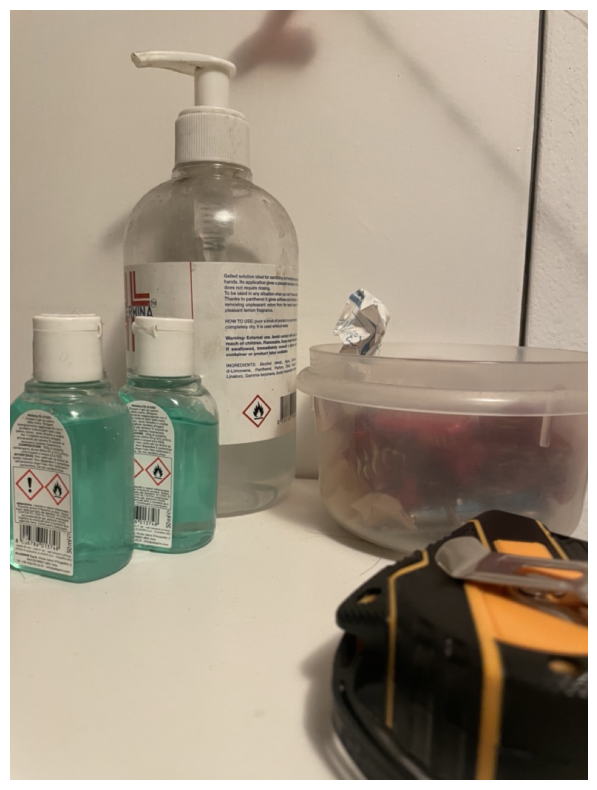

In [339]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(image)
plt.axis('off')
plt.show()

In [340]:
# masks = superpixel_region_proposals(image,max_regions=99999)

In [341]:
# ghs_red = [255, 3, 28]
# tol = 200

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# output = image.copy()
# norms = []
# for i, mask in enumerate(masks):
# 	region_colors = image[mask]
# 	non_white_black = (region_colors.mean(axis=1) > 50) & (region_colors.mean(axis=1) < 200)
# 	filtered_colors = region_colors[non_white_black]

# 	if filtered_colors.shape[0] > 0:
# 		mean_color = filtered_colors.mean(axis=0)
# 		norm = np.linalg.norm(mean_color - ghs_red)
# 		norms.append(norm)
# 		if norm < tol:
# 			output[mask] = [0, 0, 0]
# 		else:
# 			output[mask] = image[mask]

# 	# output[mask] = np.random.randint(0, 255, size=(1, 3), dtype=np.uint8)
	

# ax.imshow(output)
# ax.set_title("Top Superpixel Region Proposals")
# plt.axis('off')
# plt.show()


In [342]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 
# Set input image 
ss.setBaseImage(image) 
# Use fast but lower quality method for initial filtering 
ss.switchToSelectiveSearchFast() 
# Get region proposals 
rects = ss.process()

2692


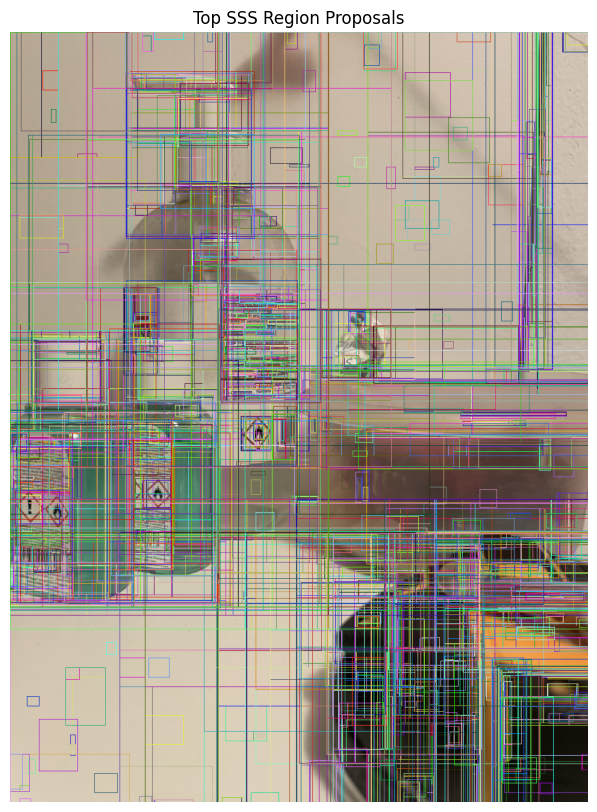

In [343]:
print(len(rects))
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

output = image.copy()

# Draw rectangles with random colors
for i, (x, y, w, h) in enumerate(rects):
	color = np.random.randint(0, 255, size=(3,), dtype=int).tolist()
	cv2.rectangle(output, (x, y), (x + w, y + h), color, thickness=1)
	
ax.imshow(output)
ax.set_title("Top SSS Region Proposals")
plt.axis('off')
plt.show()

In [344]:
print("Number of rectangles: ", len(rects))

# Remove rectangles too big
img_short_side = min(image.shape[0], image.shape[1])
max_pixel_size_perc = 0.05 ### EDIT ###
max_pixel_size = int(img_short_side * max_pixel_size_perc)
max_area = max_pixel_size ** 2

# Remove rectangles too unregular
max_aspect_ratio = 2 ### EDIT ###
min_aspect_ratio = 1/max_aspect_ratio

# Remove rectangles whose colors are too similar
max_color_stdev = 25 ### EDIT ###

rect_filtered = []
for i, (x, y, w, h) in enumerate(rects):
	if 0 < w * h < max_area and min_aspect_ratio < w / h < max_aspect_ratio:
		region_colors = image[y:y+h, x:x+w].reshape(-1, 3)
		stdev_colors = np.std(region_colors, axis=0)
		if np.all(stdev_colors > max_color_stdev):
			rect_filtered.append((x, y, w, h))

rect_filtered = np.array(rect_filtered)

print("Number of rectangles after filtering: ", len(rect_filtered))


Number of rectangles:  2692
Number of rectangles after filtering:  141


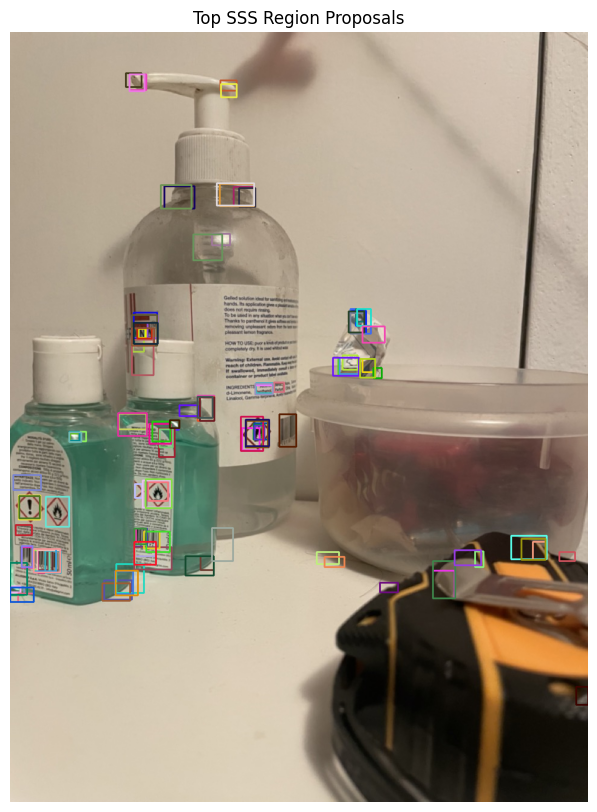

In [345]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

output = image.copy()

# Draw rectangles with random colors
for i, (x, y, w, h) in enumerate(rect_filtered):
	color = np.random.randint(0, 255, size=(3,), dtype=int).tolist()
	cv2.rectangle(output, (x, y), (x + w, y + h), color, thickness=2)
	
ax.imshow(output)
ax.set_title("Top SSS Region Proposals")
plt.axis('off')
plt.show()

In [346]:
def heuristic_score(rects, image, positive_colors, tolerance=175, color_clusters=3):
	scores = []
	# max_ratio_score = scipy_norm.pdf(1.0, loc=1.0, scale=0.35)
	for (x, y, w, h) in rects:
		
		# # Score based on size and aspect ratio
		# size = w * h
		# size_score = 1.0 / (size + 1e-5) ** 2
		# ratio = w / h if h != 0 else 0
		# ratio_score = scipy_norm.pdf(ratio, loc=1.0, scale=0.35) / max_ratio_score
		
		
		# Color score: cluster the region by colors, compare centroids to positive colors
		region = image[y:y+h, x:x+w]
		pixels = region.reshape(-1, 3)
		kmeans = KMeans(n_clusters=min(color_clusters, len(pixels)), n_init=10, random_state=42)
		kmeans.fit(pixels)
		centroids = kmeans.cluster_centers_
		dists = np.linalg.norm(centroids[:, None, :] - np.array(positive_colors)[None, :, :], axis=2).reshape(color_clusters)
		color_score = min(dists) if np.any(dists <= tolerance) else 0.0
		
		# combined_score = 0.3 * size_score\
		# 	  			+ 0.3 * ratio_score\
		# 	   			+ 0.3 * color_score

		combined_score = color_score
		scores.append(combined_score)
	return np.array(scores)

In [347]:
def nms(boxes, scores, overlapThresh):
    if len(boxes) == 0:
        return []

    boxes = boxes.astype(float)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = x1 + boxes[:, 2]
    y2 = y1 + boxes[:, 3]
    area = boxes[:, 2] * boxes[:, 3]

    idxs = np.argsort(scores)  # ascending order
    
    pick = []
    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)
        suppress = [last]
        for pos in idxs[:-1]:
            xx1 = max(x1[last], x1[pos])
            yy1 = max(y1[last], y1[pos])
            xx2 = min(x2[last], x2[pos])
            yy2 = min(y2[last], y2[pos])
            w = max(0, xx2 - xx1)
            h = max(0, yy2 - yy1)
            overlap = (w * h) / area[pos]
            if overlap > overlapThresh:
                suppress.append(pos)
        idxs = np.delete(idxs, [np.where(idxs == s)[0][0] for s in suppress])
    return boxes[pick].astype(int)

In [348]:
print("Number of rectangles after filtering: ", len(rect_filtered))

ghs_red = [255, 3, 28]

positive_colors = [ghs_red]
scores = heuristic_score(rect_filtered, image, positive_colors)

rect_valid = rect_filtered[scores > 0]
scores_valid = scores[scores > 0]

print("Number of rectangles after color validation: ", len(rect_valid))

nms_filtered = nms(rect_valid, scores_valid, overlapThresh=0.3)

print("Number of rectangles after NMS: ", len(nms_filtered))


Number of rectangles after filtering:  141
Number of rectangles after color validation:  20
Number of rectangles after NMS:  8


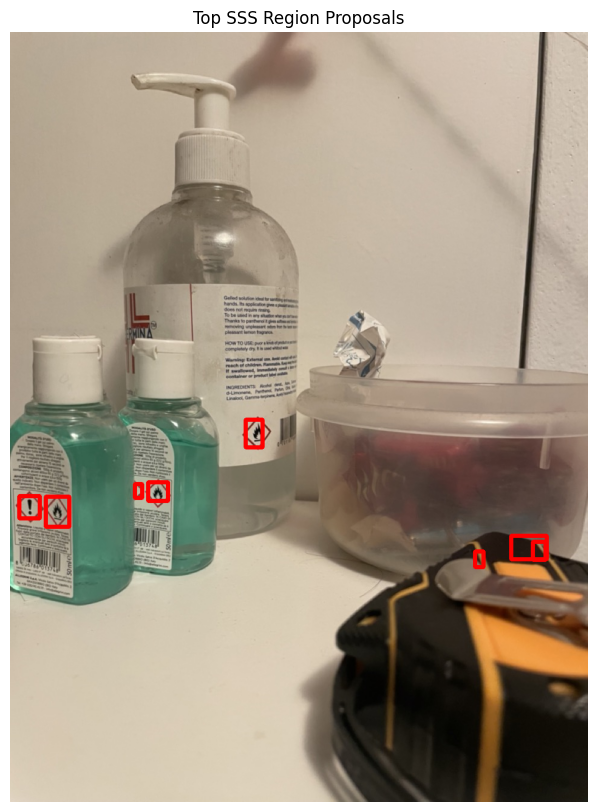

In [349]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

output = image.copy()

# Draw rectangles with random colors
for i, (x, y, w, h) in enumerate(nms_filtered):
	color = np.random.randint(0, 255, size=(3,), dtype=int).tolist()
	cv2.rectangle(output, (x, y), (x + w, y + h), [255,0,0], thickness=5)
	
ax.imshow(output)
ax.set_title("Top SSS Region Proposals")
plt.axis('off')
plt.show()

In [350]:
# ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() 
# ss.setBaseImage(image) 
# size_strategy = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategySize()
# ss.addStrategy(size_strategy)
# ss.switchToSelectiveSearchFast(base_k=500, inc_k=500, sigma=1.5) 
# rects = ss.process()